In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
import math
import os

In [2]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../../data/config/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../../data/processed/trends/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)


countries = list(assignment_language_country.keys())

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

## Time series

In [6]:
def plot_timeseries(df, col, w_err_band=True, ax=None):
    df.plot(y=("mean", col), ax=ax, legend=False)
    if w_err_band:
        if ax is None:
            ax = plt
        ax.fill_between(
            df.index,
            df["mean", col] - df["sem", col],
            df["mean", col] + df["sem", col],
            alpha=0.5,
        )


keyword_ids = dataframes[countries[0]].columns.get_level_values(1)

n_cols = 3
n_rows = math.ceil(len(countries) / n_cols)

for k_id in tqdm(keyword_ids):

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                ax = axs[i, j]
                country = countries[i * n_cols + j]
                plot_timeseries(dataframes[country], k_id, ax=ax)
                ax.set_title(country)
            except:
                pass

    fig.suptitle("Keyword ID " + k_id, fontsize=32)
    plt.tight_layout
    plt.savefig("plots/timeseries_kwid_" + k_id + ".png")
    plt.close()

# plt.savefig("plots/timeseries.png")


100%|██████████| 96/96 [07:21<00:00,  4.60s/it]


## Autocorrelation

In [7]:
keyword_ids = dataframes[countries[0]].columns.get_level_values(1)

n_cols = 3
n_rows = math.ceil(len(countries) / n_cols)

n_lags = 24

for k_id in tqdm(keyword_ids):

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                ax = axs[i, j]
                country = countries[i * n_cols + j]
                autocorr = [
                    dataframes[country]["mean", k_id].autocorr(lag)
                    for lag in range(n_lags)
                ]
                ax.plot(autocorr)
                ax.set_title(country)
            except:
                pass

    fig.suptitle("Autocorrelation Keyword ID " + k_id, fontsize=32)
    plt.tight_layout
    plt.savefig("plots/autocorr_kwid_" + k_id + ".png")
    plt.close()

# plt.savefig("plots/timeseries.png")


100%|██████████| 96/96 [06:09<00:00,  3.85s/it]


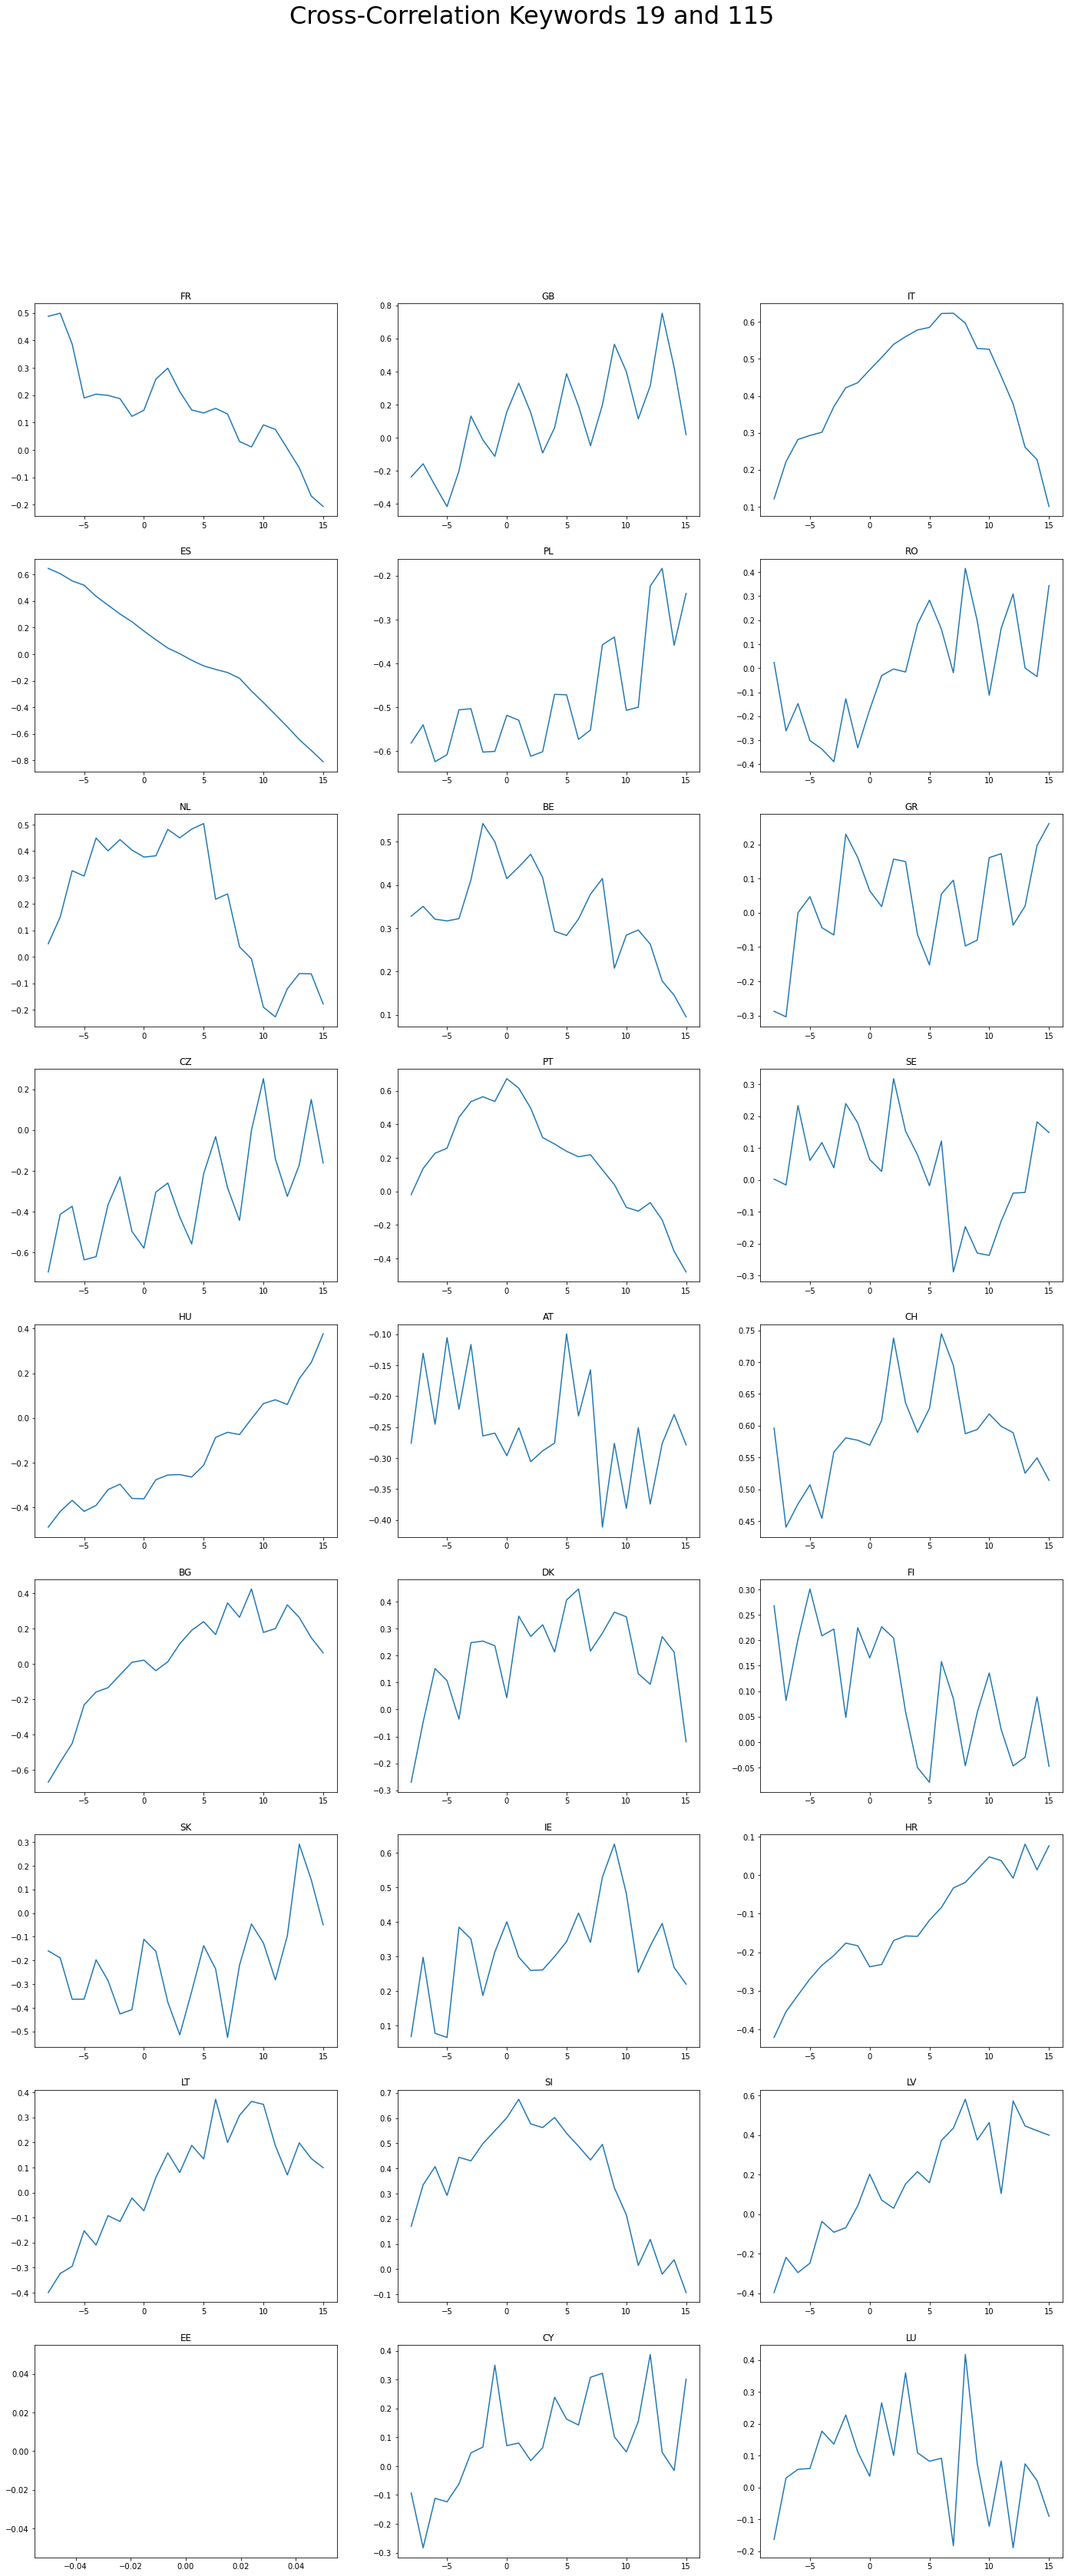

In [3]:
n_cols = 3
n_rows = math.ceil(len(countries) / n_cols)

n_lags = 16

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
fig.set_facecolor("white")

for i in range(n_rows):
    for j in range(n_cols):
        country = countries[i * n_cols + j]
        df = dataframes[country][dataframes[country].index < "2020"]
        lags = range(-int(n_lags / 2), n_lags)
        cross_corr = [
            df["mean", "19"].corr(df["mean", "115"].shift(lag)) for lag in lags
        ]
        try:
            ax = axs[i, j]
            ax.plot(lags, cross_corr)
            ax.set_title(country)
        except:
            pass

fig.suptitle("Cross-Correlation Keywords 19 and 115", fontsize=32)
plt.show()
# plt.tight_layout
# plt.savefig("plots/autocorr_kwid_" + k_id + ".png")
# plt.close()


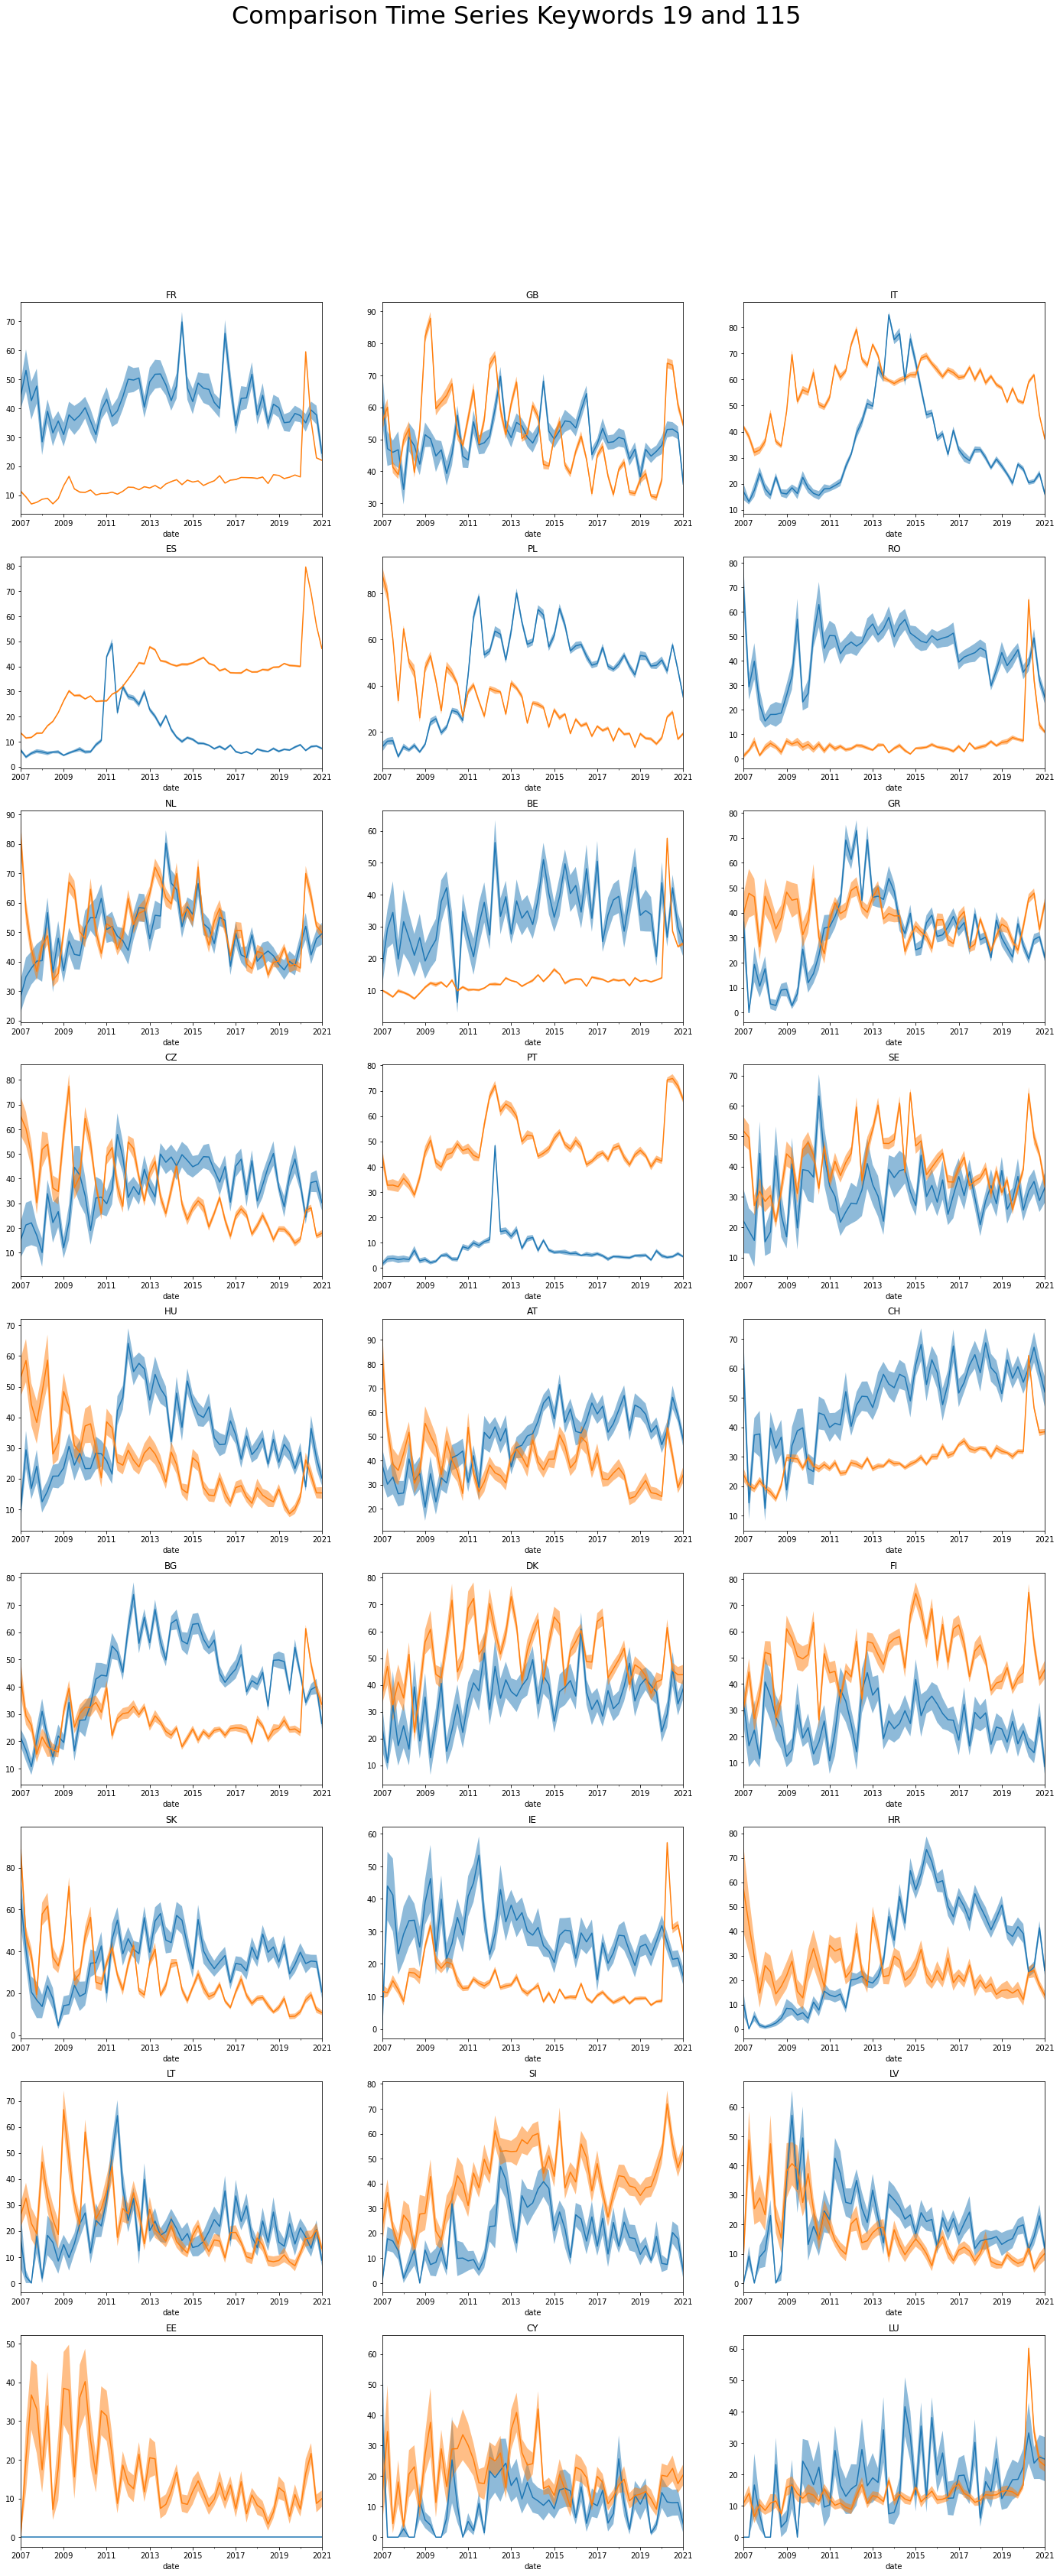

In [8]:
def plot_timeseries(df, col, w_err_band=True, ax=None):
    df.plot(y=("mean", col), ax=ax, legend=False)
    if w_err_band:
        if ax is None:
            ax = plt
        ax.fill_between(
            df.index,
            df["mean", col] - df["sem", col],
            df["mean", col] + df["sem", col],
            alpha=0.5,
        )


n_cols = 3
n_rows = math.ceil(len(countries) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
fig.set_facecolor("white")

for i in range(n_rows):
    for j in range(n_cols):
        try:
            country = countries[i * n_cols + j]
            df = dataframes[country]
            ax = axs[i, j]
            plot_timeseries(df, "19", ax=ax)
            plot_timeseries(df, "115", ax=ax)
            ax.set_title(country)
        except:
            pass

fig.suptitle("Comparison Time Series Keywords 19 and 115", fontsize=32)
plt.show()
# plt.tight_layout
# plt.savefig("plots/autocorr_kwid_" + k_id + ".png")
# plt.close()
